In [1]:
# Importing libraries and setting up the environment
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from statsmodels.genmod.families import Binomial
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.interpolate import Rbf
import numpy as np

warnings.filterwarnings("ignore")  # setting ignore as a parameter
image_format = "svg"  # setting image format as svg

In [2]:
# Define functions


# Function to read in data
def process_data(filepath, year):
    variable_data = pd.read_csv(
        filepath,
        names=[
            "LON",
            "LAT",
            "TMPVARNAME",
            "ICOHORT",
            "STANDAGE",
            "POTVEG",
            "CURRENTVEG",
            "SUBTYPE",
            "CMNT",
            "PSIPLUSC",
            "QLCON",
            "CAREA",
            "SUBAREA",
            "YEAR",
            "TOTAL",
            "MAX",
            "AVE",
            "MIN",
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
            "REGION",
        ],
    )

    variable_data = variable_data.query(f"YEAR >= {year}")

    variable_data = variable_data.drop(
        columns=[
            "TMPVARNAME",
            "ICOHORT",
            "POTVEG",
            "STANDAGE",
            "CURRENTVEG",
            "SUBTYPE",
            "CMNT",
            "PSIPLUSC",
            "QLCON",
            "CAREA",
            "SUBAREA",
            "MAX",
            "AVE",
            "MIN",
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
            "REGION",
        ]
    )

    variable_data = (
        variable_data.groupby(["LON", "LAT", "YEAR"])
        .agg({"TOTAL": "sum"})
        .reset_index()
    )
    return variable_data


# Define shared paths
shared_root_path = (
    "/processing/"
)


# smois_data_shared_path = "/data/output_bakeoff/smois_bakeoff_result.csv"
smois_data_shared_path = "/data/SMOIS.csv"


# Aggregate Future Models Return 1 Datafram
def aggregate_data(variable_models):
    future_variable = pd.concat(variable_models)
    future_variable = (
        future_variable.groupby(["LON", "LAT", "YEAR"])
        .agg({"TOTAL": "mean"})
        .reset_index()
    )

    return future_variable

In [3]:
# Import Data


# Australia

smois_model_1 = process_data(
    shared_root_path + "australia" + smois_data_shared_path, 2069
)  # SMOIS

# Canada

smois_model_2 = process_data(shared_root_path + "canada" + smois_data_shared_path, 2069)


# China

smois_model_3 = process_data(
    shared_root_path + "china" + smois_data_shared_path, 2069
)  # SMOIS

# France

smois_model_4 = process_data(
    shared_root_path + "france" + smois_data_shared_path, 2069
)  # SMOIS


# Japan

smois_model_5 = process_data(
    shared_root_path + "japan" + smois_data_shared_path, 2069
)  # SMOIS


# Norway

smois_model_6 = process_data(
    shared_root_path + "norway" + smois_data_shared_path, 2069
)  # SMOIS


# United Kingdom

smois_model_7 = process_data(
    shared_root_path + "united_kingdom" + smois_data_shared_path, 2069
)  # SMOIS


# United States CCSM4

smois_model_8 = process_data(
    shared_root_path + "united_states_1" + smois_data_shared_path, 2069
)  # SMOIS


# United States GFDL

smois_model_9 = process_data(
    shared_root_path + "united_states_2" + smois_data_shared_path, 2069
)  # SMOIS

In [4]:
# Historical data

historical_model_smois = process_data(
    shared_root_path + "historical/data/SMOIS_1.csv", 1984
)  # SMOIS

In [5]:
# Variables to list of future models dataframes
smois_models = [
    smois_model_1,
    smois_model_2,
    smois_model_3,
    smois_model_4,
    smois_model_5,
    smois_model_6,
    smois_model_7,
    smois_model_8,
    smois_model_9,
]

In [6]:
historical_model_smois.head()

,LON,LAT,YEAR,TOTAL
0,-124.5,42.5,1984,39875.6
1,-124.5,42.5,1985,39591.2
2,-124.5,42.5,1986,39939.7
3,-124.5,42.5,1987,39180.4
4,-124.5,42.5,1988,39358.6


In [7]:
# agg_Future_model Values for Variables
agg_future_model_smois = aggregate_data(smois_models)

agg_future_model_smois.head()

,LON,LAT,YEAR,TOTAL
0,-124.5,42.5,2069,39708.133333
1,-124.5,42.5,2070,39413.288889
2,-124.5,42.5,2071,39503.311111
3,-124.5,42.5,2072,39676.133333
4,-124.5,42.5,2073,39456.088889


In [8]:
merged = pd.merge(
    historical_model_smois,
    agg_future_model_smois,
    on=["LON", "LAT"],
    suffixes=["_HISTORICAL", "_FUTURE"],
)

# group the data by LAT and LON
grouped = (
    merged.groupby(["LON", "LAT"])
    .agg({"TOTAL_HISTORICAL": "mean", "TOTAL_FUTURE": "mean"})
    .reset_index()
)

# calculate the % difference in precipitation between the two time period for each grid
grouped["pct_diff"] = (
    (grouped["TOTAL_FUTURE"] - grouped["TOTAL_HISTORICAL"])
    / grouped["TOTAL_HISTORICAL"]
    * 100
)


# perform a t-test on each grid to test if the change is significant
grouped["t_statistic"], grouped["p_value"] = ttest_rel(
    grouped["TOTAL_HISTORICAL"], grouped["TOTAL_FUTURE"]
)
# if the p-value is less than 0.05, change pvalue to 1, otherwise leaave blank
grouped["p_value"] = grouped["p_value"].apply(lambda x: 1 if x < 0.05 else 0)

# remove rows where pct_diff is greater than 100
# condition = grouped['pct_diff'] > 10
# Drop the rows where the condition is True
# grouped.drop(grouped[condition].index, inplace=True)


def remove_outliers(df):
    Q1 = df["pct_diff"].quantile(0.25)
    Q3 = df["pct_diff"].quantile(0.75)
    IQR = Q3 - Q1
    lower_cutoff = Q1 - 1.5 * IQR
    upper_cutoff = Q3 + 1.5 * IQR
    outliers = (df["pct_diff"] < lower_cutoff) | (df["pct_diff"] > upper_cutoff)
    mean = df["pct_diff"].mean()
    df.loc[outliers, "pct_diff"] = mean
    return df

grouped = remove_outliers(grouped)

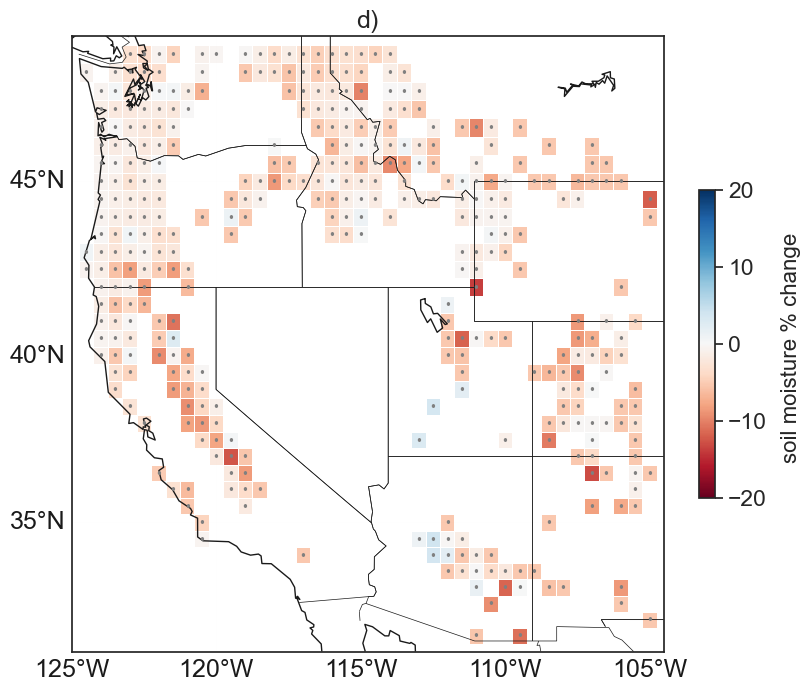

In [12]:
# add missing grids with -99999 value
lons = np.arange(-125, -104.5, 0.5)
lats = np.arange(31, 49, 0.5)
for lon in lons:
    for lat in lats:
        if not ((grouped["LON"] == lon) & (grouped["LAT"] == lat)).any():
            grouped = grouped.append({"LON": lon, "LAT": lat, "pct_diff": -99999, "p_value": 0}, ignore_index=True)

# sort the data by longitude and latitude
grouped = grouped.sort_values(by=["LON", "LAT"])

# interpolate data to 0.25 by 0.25
lon_new, lat_new = np.meshgrid(np.arange(-125, -104.5, 0.5), np.arange(31, 49, 0.5))
z = griddata((grouped["LON"], grouped["LAT"]), grouped["pct_diff"], (lon_new, lat_new), method="linear")

# set missing values to white
cmap = plt.get_cmap("RdBu")
#cmap.set_bad(color="white")

# plot the data using pcolormesh
plt.figure(figsize=(23, 8))
sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5}, font_scale=1.5)
m = Basemap(
    projection="mill",
    llcrnrlat=31,
    llcrnrlon=-125,
    urcrnrlat=49,
    urcrnrlon=-104.5,
    resolution="l",
)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
x, y = m(lon_new, lat_new)

# set the color of grids with pct_diff == -99999 to white
z_masked = np.ma.masked_where(z == -99999, z)
m.pcolormesh(x, y, z_masked, cmap=cmap, vmin=-20, vmax=20,edgecolor="white", linewidth=0.5)

# plot the missing grids
for i, row in grouped.iterrows():
    if row["p_value"] == 1:
        x, y = m(row["LON"], row["LAT"])
        plt.text(x, y, "•", fontsize=10, ha="center", va="center", color="grey")

# set the intervals for parallels and meridians
lat_interval = 5
lon_interval = 5

# draw parallels and meridians
parallels = np.arange(25, 50, lat_interval)
meridians = np.arange(-130, -104.5, lon_interval)
m.drawparallels(
    parallels, labels=[True, False, False, False], linewidth=0.001
)
m.drawmeridians(
    meridians, labels=[False, False, False, True], linewidth=0.001
)

# add colorbar
c = plt.colorbar(orientation="vertical", shrink=0.5, pad=0.02)
c.set_label(
    label="soil moisture % change ",
    fontsize=16,
    labelpad=10,
)
c.ax.tick_params()
c.set_ticks(np.arange(-20, 21, 10))

# add title
plt.title("d)")
plt.savefig("../figures/smois_diff_map.svg", format="svg", dpi=1200, bbox_inches="tight")
# show the plot
plt.show()

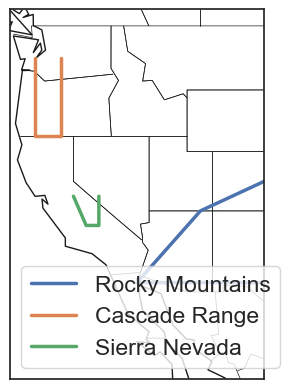

In [10]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Create a new Basemap instance with the desired projection and extent
m = Basemap(llcrnrlon=-125,llcrnrlat=25,urcrnrlon=-105,urcrnrlat=50, projection='mill', lat_1=33,lat_2=45,lon_0=-95)

# Draw coastlines and political boundaries
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Draw polygons around mountain ranges using their coordinates
mountain_ranges = {
    'Rocky Mountains': [[-105, 39], [-110, 37], [-115, 32], [-105, 32]],
    'Cascade Range': [[-123, 47], [-123, 42], [-121, 42], [-121, 47]],
    'Sierra Nevada': [[-120, 38], [-119, 36], [-118, 36], [-118, 38]],
    # add more mountain ranges and coordinates as needed
}

for range_name, range_coords in mountain_ranges.items():
    x, y = m(*zip(*range_coords))
    m.plot(x, y, label=range_name)

plt.legend(loc='lower left')
plt.show()
